In [10]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import classification_report
import seaborn as sns

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Train Loss: 7.8001, Train Accuracy: 0.00%, Val Loss: 8.8798, Val Accuracy: 0.00%
Epoch [2/30], Train Loss: 6.5186, Train Accuracy: 0.19%, Val Loss: 6.3266, Val Accuracy: 4.41%
Epoch [3/30], Train Loss: 6.2247, Train Accuracy: 0.38%, Val Loss: 5.7376, Val Accuracy: 8.82%
Epoch [4/30], Train Loss: 5.9161, Train Accuracy: 1.14%, Val Loss: 4.7491, Val Accuracy: 19.12%
Epoch [5/30], Train Loss: 5.1020, Train Accuracy: 3.99%, Val Loss: 3.5024, Val Accuracy: 35.29%
Epoch [6/30], Train Loss: 4.2771, Train Accuracy: 13.50%, Val Loss: 2.6156, Val Accuracy: 50.00%
Epoch [7/30], Train Loss: 3.3524, Train Accuracy: 20.34%, Val Loss: 1.7950, Val Accuracy: 58.82%
Epoch [8/30], Train Loss: 2.4106, Train Accuracy: 37.83%, Val Loss: 0.7466, Val Accuracy: 85.29%
Epoch [9/30], Train Loss: 1.6685, Train Accuracy: 57.98%, Val Loss: 0.5164, Val Accuracy: 85.29%
Epoch [10/30], Train Loss: 1.0993, Train Accuracy: 71.29%, Val Loss: 0.4049, Val Accuracy: 88.24%
Epoch [11/30], Train Loss: 0.6888, Tr

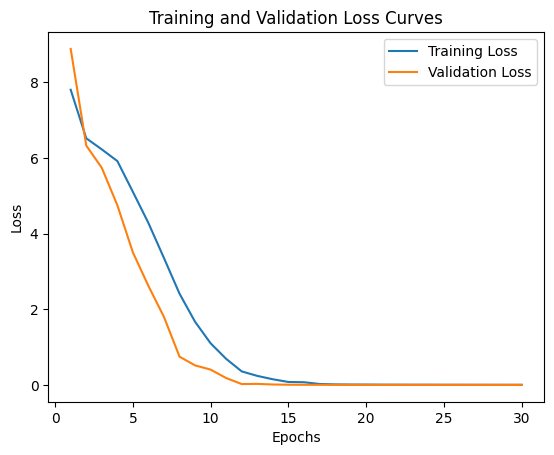

In [11]:
# Classification model to classify the reconstructed images to the real images

# Custom Dataset for Classification with Labels
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform
        
        # Create a mapping to map labels from 1-682 to 0-525
        label_values = sorted(int(name.split('mdvs')[1].split('.jpg')[0].strip()) for name in self.image_names)
        self.label_mapping = {val: idx for idx, val in enumerate(label_values)}  # Map to continuous range

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx].strip())
        image = Image.open(img_name).convert('L')

        # Extract label from the image name
        original_label = int(self.image_names[idx].strip().split('mdvs')[1].split('.jpg')[0].strip())
        label = self.label_mapping[original_label]

        if self.transform:
            image = self.transform(image)

        return image, label
        

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset and DataLoader
image_dir_train = 'medieval_sinhala'
train_dataset = CustomImageDataset(image_dir_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

image_dir_val = 'Val_Dataset_For_Classification'
val_dataset = CustomImageDataset(image_dir_val, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Load the pre-trained ResNet50 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Modify the first convolutional layer to accept single-channel input (grayscale)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Output layer with 526 classes (unique images)
num_classes = 526
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop with debugging for shapes and labels
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    # Average loss for the training epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store the average training loss
    train_accuracy = 100 * correct / total
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Forward pass for validation
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
    
    # Average loss for the validation epoch
    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * val_correct / val_total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'resnet50_model.pth')

# Plot the loss after training
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [12]:
# Function to save training and validation losses to a CSV file
def save_losses_to_csv(train_losses, val_losses, filename='Classification_losses.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])
        for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
            writer.writerow([i+1, train_loss, val_loss])

# After the training loop, save the losses
save_losses_to_csv(train_losses, val_losses, filename='Classification_losses.csv')

In [ ]:
# Function to load training and validation losses from a CSV file
def load_losses_from_csv(filename='Classification_losses.csv'):
    train_losses = []
    val_losses = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        for row in reader:
            epoch, train_loss, val_loss = row
            train_losses.append(float(train_loss))
            val_losses.append(float(val_loss))

    return train_losses, val_losses

# Load the losses from CSV
train_losses, val_losses = load_losses_from_csv('Classification_losses.csv')

# Plot loaded losses
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))

# Plot training and validation losses
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Folder containing the images (mdvsXX.jpg)
image_dir = 'medieval_sinhala'

# Create a list to store the mdvs numbers present in the dataset
mdvs_present = []

# Loop over the files in the directory and extract the number from the filenames
for filename in os.listdir(image_dir):
    if filename.startswith('mdvs') and filename.endswith('.jpg'):
        # Extract the number part, e.g., 'mdvs10.jpg' -> 10
        number_part = int(filename.split('mdvs')[1].split('.jpg')[0].strip())
        mdvs_present.append(number_part)

# Sort the mdvs numbers to maintain the order
mdvs_present = sorted(mdvs_present)

# Create the mapping from mdvs numbers to class labels (0 to len(mdvs_present)-1)
mdvs_to_class_mapping = {mdvs_number: idx for idx, mdvs_number in enumerate(mdvs_present)}

print("MDVS numbers present:", mdvs_present)
print("MDVS to class mapping:", mdvs_to_class_mapping)


MDVS numbers present: [1, 4, 5, 6, 7, 8, 10, 13, 15, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 34, 35, 36, 38, 39, 40, 41, 42, 43, 46, 49, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 87, 91, 92, 93, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 112, 113, 114, 115, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 152, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 216, 217, 220, 221, 222, 224, 225, 227, 228, 230, 231, 233, 234, 236, 237, 238, 242, 244, 245, 247, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277

In [11]:
# Classification Model (ResNet50) Testing on Reconstructed Images
# The Metrics used are Accuracy, Top-5 Accuracy, Macro-averaged Precision, Recall, F1-score, and Weighted-averaged F1-score

# Custom Dataset for Reconstructed Images using mdvs_to_class_mapping
class ReconstructedImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx].strip())
        image = Image.open(img_name).convert('L')  # Convert image to grayscale ('L')

        # Extract mdvs number from the filename (e.g., 'mdvs10_reconstructed_1.png')
        try:
            mdvs_number = int(self.image_names[idx].split('_')[0].split('mdvs')[1])

            # Use the mapping to get the actual class label
            if mdvs_number in mdvs_to_class_mapping:
                label = mdvs_to_class_mapping[mdvs_number]
            else:
                raise KeyError(f"mdvs number {mdvs_number} not found in mapping")

            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"Error processing image {img_name}: {e}")
            return None, None  # Handle errors gracefully


# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset and DataLoader for reconstructed images
reconstructed_dir = 'reconstructed_images'
reconstructed_dataset = ReconstructedImageDataset(reconstructed_dir, transform=transform)
reconstructed_loader = DataLoader(reconstructed_dataset, batch_size=16, shuffle=False)

# Load the trained ResNet50 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)

# Modify the first layer for grayscale input (1 channel)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the output layer to match the number of classes
num_classes = len(mdvs_present)  # Should be 526
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load('resnet50_model.pth'))
model = model.to(device)
model.eval()

# Lists to store true and predicted labels for metrics calculation
all_true_labels = []
all_predicted_labels = []

# Predict class for each reconstructed image and compute metrics
correct = 0
total = 0
topk_correct = 0
k = 5

with torch.no_grad():
    for images, actual_labels in reconstructed_loader:
        # Skip any invalid entries returned as None
        images = [img for img in images if img is not None]
        actual_labels = [lbl for lbl in actual_labels if lbl is not None]

        if len(images) == 0 or len(actual_labels) == 0:
            continue

        images = torch.stack(images).to(device)
        actual_labels = torch.tensor(actual_labels).to(device)

        # Forward pass to get predictions
        outputs = model(images)

        # Get predicted class
        _, predicted = torch.max(outputs, 1)

         # Calculate top-k accuracy
        _, topk_predictions = outputs.topk(k, dim=1)
        topk_correct += torch.sum(topk_predictions.eq(actual_labels.view(-1, 1).expand_as(topk_predictions)).any(dim=1)).item()


        # Calculate accuracy
        correct += (predicted == actual_labels).sum().item()
        total += actual_labels.size(0)

        # Store labels for metrics
        all_true_labels.extend(actual_labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

        # print predictions for each image
        for i in range(len(predicted)):
            print(f"Predicted: {predicted[i].item()}, Actual: {actual_labels[i].item()}")

# Calculate and print accuracy
print('---------------------------------------------------')
print('Metrics for Classification of Reconstructed Images:')
print('---------------------------------------------------')
if total > 0:
    accuracy = 100 * correct / total
    topk_accuracy = 100 * topk_correct / total
    print(f"Total images: {total}, Correct predictions: {correct}")
    print(f"Accuracy on reconstructed images: {accuracy:.2f}%")
    print(f"Top-{k} Accuracy on reconstructed images: {topk_accuracy:.2f}%")
else:
    print("No valid images found for classification.")

mdvs_present = [str(label) for label in mdvs_present]

# Calculate the classification report
report_dict = classification_report(all_true_labels, all_predicted_labels, target_names=mdvs_present, output_dict=True)

# Extract macro-averaged and weighted-averaged metrics
macro_precision = report_dict['macro avg']['precision']
macro_recall = report_dict['macro avg']['recall']
macro_f1 = report_dict['macro avg']['f1-score']
weighted_f1 = report_dict['weighted avg']['f1-score']

# Print only the summary of metrics
print("\nSummary of Classification Report:")
print(f"Overall Accuracy: {accuracy:.2f}%")
print(f"Macro-averaged Precision: {macro_precision:.4f}")
print(f"Macro-averaged Recall: {macro_recall:.4f}")
print(f"Macro-averaged F1-score: {macro_f1:.4f}")
print(f"Weighted-averaged F1-score: {weighted_f1:.4f}")

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24836\812947295.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default v

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 6, Actual: 6
Predicted: 70, Actual: 70
Predicted: 70,